# Нейронная на сеть на мобильном устройстве

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

print("TensorFlow Version:", tf.__version__)
print("TensorFlow Hub Version: ", hub.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.8.3
TensorFlow Hub Version:  0.12.0
GPU Device Not Found. Running on CPU


# <b>Подготовка файлов для работы с локального диска</b>

## Загрузка данных на локальный диск

In [2]:
import urllib.request, urllib.error
import zipfile

# Загрузка архива
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
fname = 'cats_vs_dogs'
local_zip = urllib.request.urlretrieve(url, fname + '.zip')
local_zip = local_zip[0]

Распаковка в текущую директорию. Распакауем все, так как иначе нужная папка (`PetImages`) в данном архиве не обнаруживается.

In [3]:
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('./data')

Удалим лишние файлы и переименуем папку с изображениями в удобную для дальнейшего использования - `cats_vs_dogs`.

In [4]:
import os

zip_content = os.listdir('./data')

In [5]:
os.remove('./data/' + zip_content[0])
os.remove('./data/' + zip_content[2])

os.renames('./data/PetImages',
           f'./data/{fname}')

## Настройка и проверка директорий

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями классов и количество этих классов. 

In [4]:
from pathlib import Path

# Базовая директория
base_dir = Path('./data/cats_vs_dogs')
# base_dir = '/content/drive/MyDrive/Sber DS/Diploma/data/cats_vs_dogs/'  # for colab
classes = os.listdir(base_dir)

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['Cat', 'Dog']
Количество классов: 2


Теперь можно удалить загруженный ранее архив.

In [8]:
# deleting the zip file from system
os.remove(fname + '.zip')

## Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник кода](https://github.com/tensorflow/datasets/issues/2188)).

In [9]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir /f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [10]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

Cat
[FILE_CORRUPT] data\cats_vs_dogs\Cat\10125.jpg DELETED
[ERR] data\cats_vs_dogs\Cat\10404.jpg: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\10501.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\10820.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\11210.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\11565.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\11874.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\11935.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\140.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\2663.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\3300.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\3491.jpg DELETED
[ERR] data\cats_vs_dogs\Cat\4351.jpg: Input size should match (header_size + row_size * abs_height) but they differ by 2 [Op:DecodeImage] DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\4833.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\5553.jpg DELETED
[FILE_CORRUPT]

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [5]:
cat_dir = base_dir / classes[0]
dog_dir = base_dir / classes[1]

cat_fnames = os.listdir(cat_dir)
dog_fnames = os.listdir(dog_dir)

print('cat:', len(cat_fnames))
print('dog:', len(dog_fnames))

cat: 12475
dog: 12465


Таким образом, наши классы сбалансированы, в дальнейшем при оценке качества работы модели мы можем использовать метрику `accuracy`, которая показывает число правильно предсказанных объектов. Если же классы были несбалансированы, нам пришлось бы оценивать модель по метрикам `precision` и `recall`, которые позволяют более прицельно оценить качество работы модели (доля правильно предсказанных объектов позитивного класса из всех объектов, помеченных моделью позитивными, и доля правильно предсказанных объектов позитивного класса среди всех истинных позитивных объектов, соответственно).

Посмотрим на названия отдельных файлов в тренировочном наборе фотографий.

In [12]:
print(cat_fnames[90:95])
print(dog_fnames[90:95])

['10078.jpg', '10079.jpg', '1008.jpg', '10080.jpg', '10081.jpg']
['10078.jpg', '10079.jpg', '1008.jpg', '10080.jpg', '10081.jpg']


## Визуализация оригинальных изображений

Посмотрим на восемь фотографий из обеих субдиректорий - 4 фотографии с выжженной территорией и 4 с обычной.

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

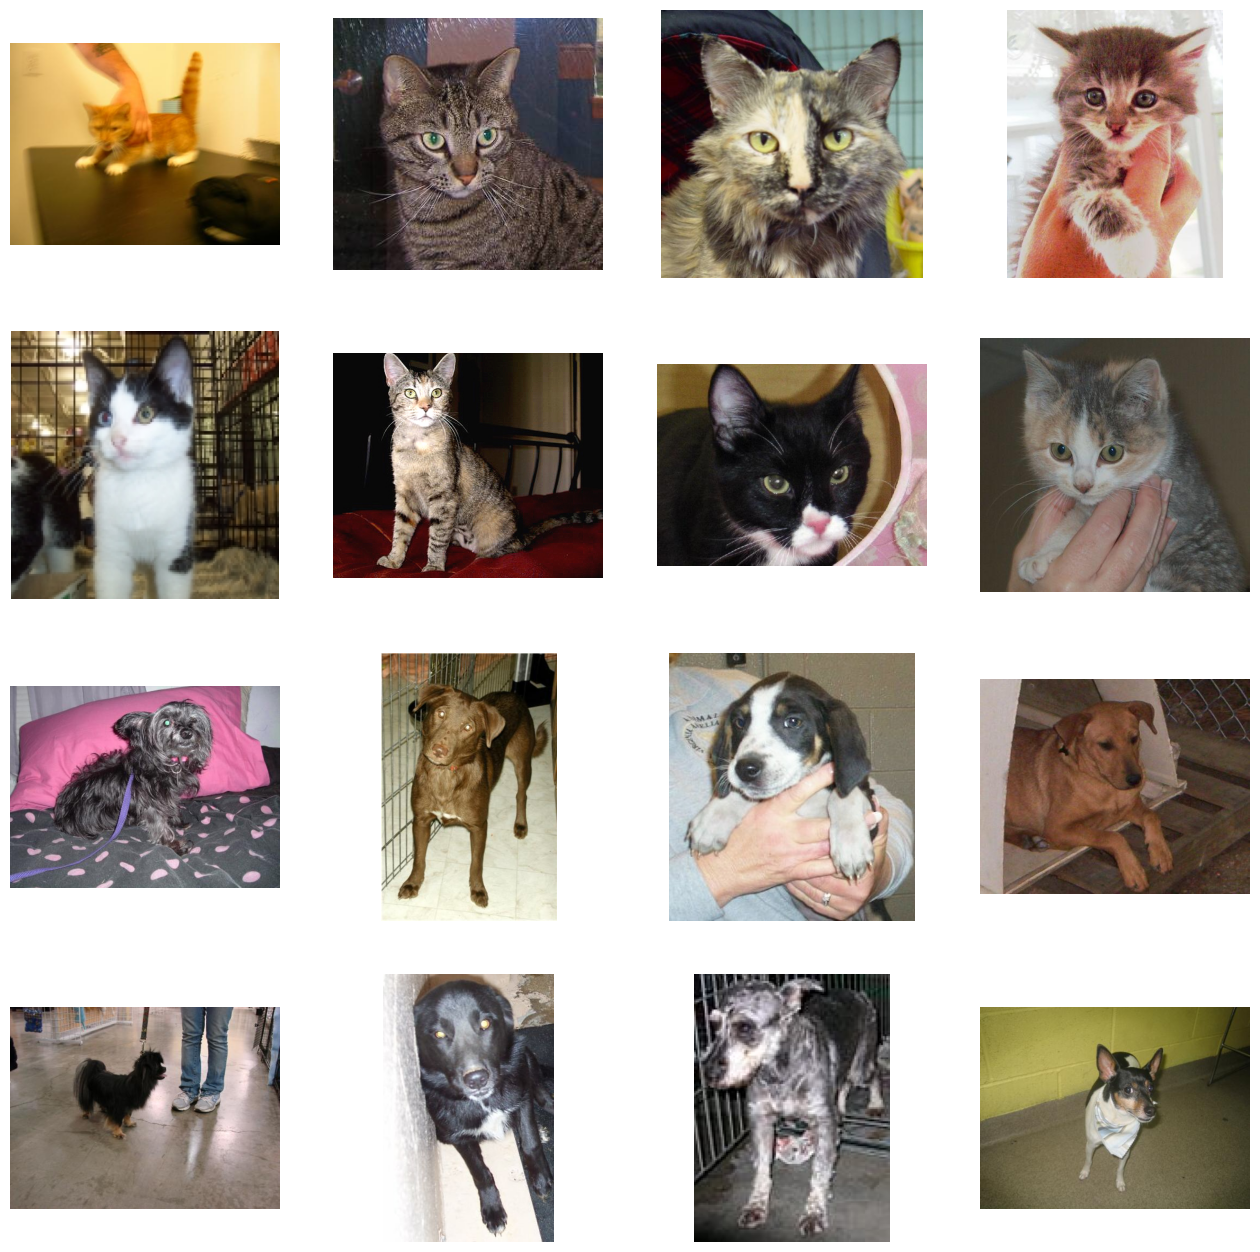

In [7]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pic = [os.path.join(cat_dir, fname)
                for fname in cat_fnames[pic_index-8:pic_index]]
next_dog_pic = [os.path.join(dog_dir, fname)
                for fname in dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pic+next_dog_pic):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    # Отключить оси
    sp.axis(False)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и и соотноешние сторон, поэтому их необходимо привести к единому стандарту на стадии формирования датасетов для нейронной сети. Этим мы сейчас и займемся.

# <b>Гиперпараметры для модели с переносом обучения</b>

В самом начале обозначим гиперпараметры для будущей модели, это позволит нам уже сейчас начать подготавливать необходимые команды с этими данными для дальнейшего использования. Также определим, какую предобученную модель мы будем использовать для нашей модель.

- "mobilenet_v2", 224, 1280  
или
- "inception_v3", 299, 2048.

In [13]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Split вручную

Так как готовых инструментов для формирования датасета из трех частей (тренировка, валидация, тест) в tensorflow нет, предварительно необходимо разделить все изображения на соответствующие директории, внутри которых будут папки с классами.

Для удобства рабботы с модулем `Path` назначим для каждого класса переменную.

In [14]:
cats = 'Cat'
dogs = 'Dog'

# копируем все файлы на всякий случай
# shutil.copytree(src=base_dir, dst='./data_new')

# <b>Создание датасетов</b>

## Подготовка датасетов

Для обучения модели и затем конвертации ее в облегченную версию все предварительно разделенные по папкам изображения необходимо перевести в формат `dataset`. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`.

Для корректной работы кода, создающего облегченную версию нашей модели, который мы позаимствовали из курса по компьютерному зрению, тренировочный и валидационный датасеты должны иметь достаточно большой батч, тогда как тестовый датасет должен выдавать по одному изображению зараз, то есть батч должен равняться 1. 

Весь необходимый код оформим в функцию, которая и проделает все операции.

In [20]:
def datasets_prep(base_directory=base_dir,
                  seed=123,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='binary'):
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            base_dir,
                            label_mode=label_mode,
                            validation_split=0.2,
                            subset='training',
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            base_dir,
                            label_mode=label_mode,
                            validation_split=0.2,
                            subset='validation',
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=1)
    
    # разделяем валидационный тест на две части
    val_ds_num = len(val_ds)
    take = int(val_ds_num/2)
    test_ds = val_ds.take(take)
    val_ds = val_ds.skip(take)
    
    val_ds = val_ds.rebatch(32)
    # print('Files for final validation dataset:', val_ds.cardinality())
    print('Files for test dataset:', test_ds.cardinality())
    
    return train_ds, val_ds, test_ds

Проверим корректность метода, который мы применили для выделения тестового датасета из валидационного - изображения в обоих датасетах не должны повторяться.

In [21]:
dataset = tf.data.Dataset.range(10)
take = int(len(dataset)/2)
print(take)

test = dataset.take(take)
print('test:', list(test.as_numpy_iterator()))
dataset = dataset.skip(take)
print('valid:', list(dataset.as_numpy_iterator()))

5
test: [0, 1, 2, 3, 4]
valid: [5, 6, 7, 8, 9]


Как видим, при использовании данной последовательности методов `take` и `skip` элементы действительно разделяются без повторов.

In [22]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 24940 files belonging to 2 classes.
Using 19952 files for training.
Found 24940 files belonging to 2 classes.
Using 4988 files for validation.


AttributeError: 'SkipDataset' object has no attribute 'rebatch'

Проверим созданные датасеты на соответствие заданным выше параметрам.

In [25]:
for ds in (train_batches, validation_batches, test_batches):
    for image_batch, label_batch in ds.take(1):
        print(image_batch.shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(1, 224, 224, 3)


Как и требовалось, тренировочный и валидационный датасеты содержат по 32 изображения в батче, тестовый - 1.

Проверим классы, верно ли отработал данный инструмент.

In [26]:
for ds in (train_batches, validation_batches, test_batches):
    print(ds.class_names)
    
class_names = train_batches.class_names
num_classes = len(class_names)

['Cat', 'Dog']
['Cat', 'Dog']
['Cat', 'Dog']


## Визуализация изображений из `train_batches`

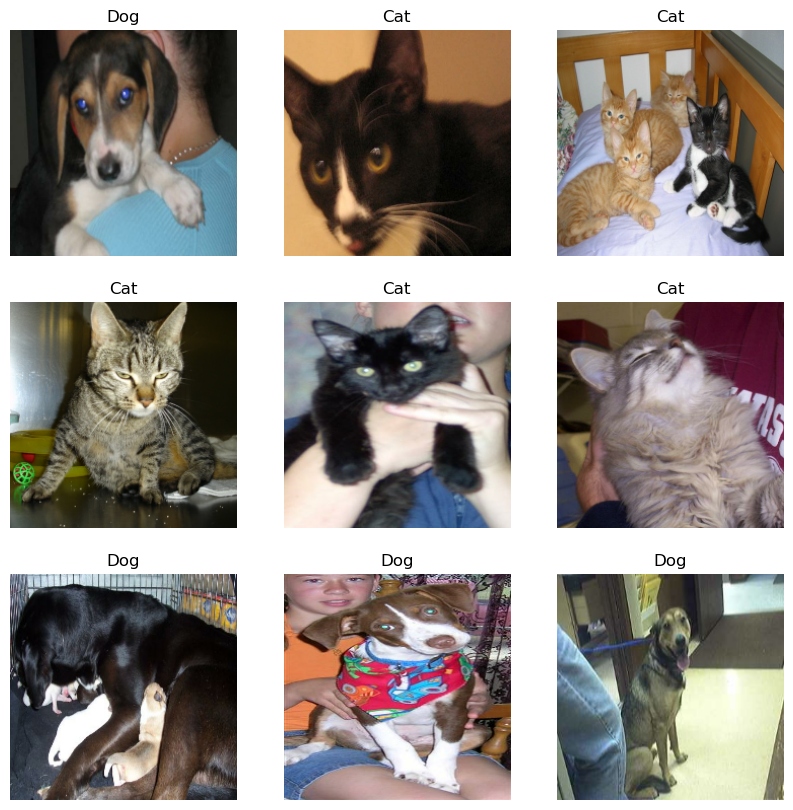

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        binary_class = int(labels[i, 0])
        plt.title(class_names[binary_class])
        plt.axis('off')

Также возьмем одно из изображений из получившегося датасета и посмотрим, получили ли мы желаемое разрешение. Это изображение пригодится нам в дальнейшм, поэтому сохраним его в переменную `one_pic`.

(224, 224, 3)


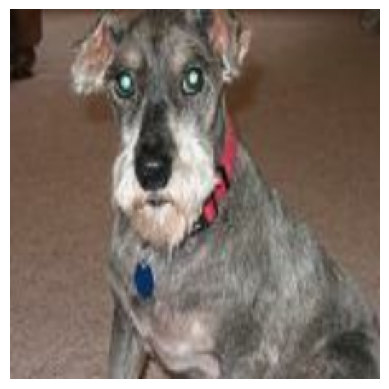

In [28]:
# одно случайное изображение
for images, labels in train_batches.take(1):
    one_pic = images[1].numpy()
    break

print(one_pic.shape)
plt.axis('off')
plt.imshow(one_pic.astype('uint8'));

Итак, датасет для модели создан, все фотографии приведены к единому разрешению, можно переходить к обработке данных для тренировки модели. Обработка данных для нашей модели состоит из двух частей: нормализация значений массива (`rescale`) и агументация данных. Подготовим обе части и запустим две модели - без ааугментации и с ней, чтобы посмотреть, как этот блок слоев влияет на работу модели. 

# <b>Подготовка изображений</b>

## Rescale

### Создание слоя Rescale

Создадим слой для будущей модели, который приведет значения массивов изображений к стандартному виду (от 0 до 1). Это стандартная операция по подготовке изображений для обучения нейросети. Так как даный слой будет первым в нашей сети, укажем `input_shape=IMAGE_SIZE+(3,)`.

In [29]:
rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255,
                              input_shape=IMAGE_SIZE+(3,),
                              name='Rescaling')
])

### Визуализация работы Rescale

Проверим качество работы слоя на фотографии, которую мы использовали выше.

Миниммальное и максимальное значение пикселей: 0.0 0.99243706


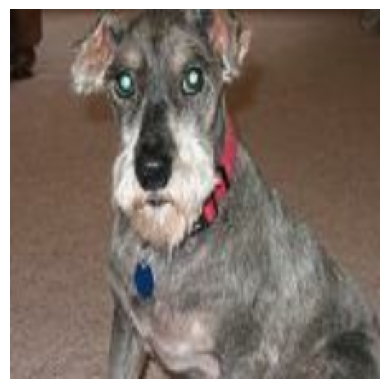

In [30]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через слой
result = rescale(np.expand_dims(one_pic, axis=0))

# вернем результату размерность 3 для отображения
result = np.squeeze(result)

plt.axis('off')
plt.imshow(result)

# print("Picture's shape:", result.shape)
print("Миниммальное и максимальное значение пикселей:", result.min(), result.max())

Как видим, слой отработал ожидаемым образом, значения пикселей приведены к диапазону от 0 до 1.

## Аугментация данных

Следующий шаг - аугментация данных. Так как наш датасет создан из сравнительно небольшого набора данных, а именно из нарезанных спутниковых снимков, то для избежания переобучения мы воспользуемся возможностями библиотеки `keras` по искусственному расширению количества фотографий через внешнее изменение имеющихся. Создадим последовательность слоев `RandomFlip` (зеркальное отображение изображения в случайном порядке), `RandomRotation` (поворот изображения по часовой стрелке на случайный угол), `RandomZoom` (увеличение и уменьшение изображения в случайном порядке), а также `RandomContrast`. Это не все воможности аугментации, представленные в библиотеке `TensorFlow`, но на данном этапе мы остановимся на этих методах.

### Создание последовательности для агументации данных

In [31]:
import tensorflow as tf

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical', name='RandomFlip'),
    tf.keras.layers.RandomRotation(factor=1, fill_mode='reflect',
                                   name='RandomRotation'),
    tf.keras.layers.RandomZoom(height_factor=(-0.7, 0.4), name='RandomZoom'),
    tf.keras.layers.RandomContrast(factor=(0.3, 1), name='RandomContrast')
])

### Визуалиация работы слоя `data_augmentation`

Как и в случае с созданием датасета, проверим на уже использованном изображении из тренировочного датасета, как работает последовательность по аугментации данных. Если следующий блок с кодом запустить несколько раз, то мы увидим, как меняется изображение, проходя через вышеописанные слои.

> _**Note**: В версии tf 2.11.0 при выполнении нижеследующего кода выводятся предупреждения, которые не влияют на качество работы модели._

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


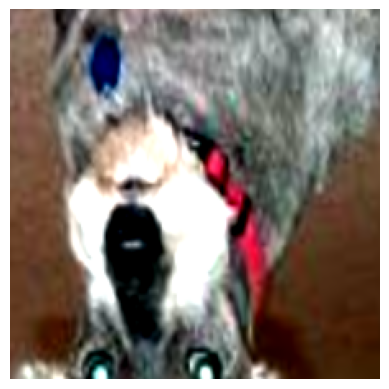

In [32]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через последовательность слоев
result_for_aug = np.expand_dims(result, axis=0)
augmented = data_aug(result_for_aug)
print(augmented.shape)

plt.axis('off')

# вернем результату размерность 3 для отображения
plt.imshow(augmented.reshape(result.shape));

Итак, обе последовательности успешно справляются с поставленными перед ними задачами. Переходим к созданию и обучению моделей.

## Оптимизация работы кэша

Оптимизируем работу кэша следующим кодом:

In [33]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

# <b>Модель</b>

## Модуль Hub | `feature_extractor_layer`

Создадим `feature_extractor`, который извлечет веса из предобученной модели `tensorflow` для переноса обучения на нашу модель.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [34]:
do_fine_tuning = False

In [35]:
feature_extractor = hub.KerasLayer(
                            MODULE_HANDLE,
                            # input_shape=IMAGE_SIZE + (3,),
                            output_shape=[FV_SIZE],
                            trainable=do_fine_tuning
)

## Архитектура модели

In [36]:
print('Building model with', MODULE_HANDLE)

model = tf.keras.Sequential([
        rescale,
        data_aug,
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

## Обучение модели

In [38]:
EPOCHS = 1

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

624/624 [==============================] - 4164s 7s/step - loss: 0.2732 - accuracy: 0.8809 - val_loss: 0.0519 - val_accuracy: 0.9832


## Экспорт модели

In [39]:
CATS_VS_DOGS_SAVED_MODEL = "./saved/exp_saved_model"

In [40]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

INFO:tensorflow:Assets written to: ./saved/exp_saved_model\assets


INFO:tensorflow:Assets written to: ./saved/exp_saved_model\assets


In [41]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)
loaded

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x19e7b0f08b0>

In [42]:
print(list(loaded.signatures.keys()))

['serving_default']


In [43]:
infer = loaded.signatures['serving_default']
infer

<ConcreteFunction signature_wrapper(*, sequential_input) at 0x19F404A66D0>

In [44]:
print(infer.structured_input_signature)

((), {'sequential_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='sequential_input')})


In [45]:
print(infer.structured_outputs)

{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


# <b>Конвертация модели в формат `tflite`</b>

In [46]:
CATS_VS_DOGS_SAVED_MODEL = "./saved/exp_saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter

## Оптимизация сконвертированной модели

### Post-Training Quantization

In [47]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations

[<Optimize.DEFAULT: 'DEFAULT'>]

### Post-Training Integer Quantization

In [48]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

In [50]:
# работа оператора yield
def data_gen():
    for i in range(3):
        yield [i]
        
a = data_gen()
print(a)  # generator object

for j in a:
    print(j)

<generator object data_gen at 0x0000019E7AFB4E40>
[0]
[1]
[2]


In [53]:
converter.representative_dataset = representative_data_gen
converter.representative_dataset

<function __main__.representative_data_gen()>

### Full Integer Quantization

In [54]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_ops

[<OpsSet.TFLITE_BUILTINS_INT8: 'TFLITE_BUILTINS_INT8'>]

## Конвертация

In [57]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

## Проверка `tflite` модели с использованием  интерпретатора Python

### Загрузка облегченной модели и локализация тензоров

In [58]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [59]:
input_index

0

In [60]:
output_index

181

### Сбор данных из тестовой выборки для оценки результативности 

In [95]:
for img, label in test_batches.take(1):
    # print(img)
    print(label.numpy())

[[1.]]


In [205]:
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:26<00:00,  3.26s/it]


### Визуализация предсказания в виде изображения

In [171]:
# class_names = [name.lower() for name in classes]
# class_names

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], int(true_label[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)  # уменьшение размерности

    plt.imshow(img.astype('uint8'), cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

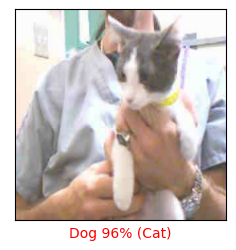

In [204]:
index = np.random.randint(10)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()